In [5]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
data = pd.read_csv('reddit_depression_dataset.csv')
data

C:\Users\koval\AppData\Local\Temp\ipykernel_16340\1325583078.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('reddit_depression_dataset.csv')


,Unnamed: 0,subreddit,title,body,upvotes,created_utc,num_comments,label
0,47951,DeepThoughts,Deep thoughts underdog,"Only when we start considering ourselves, the ...",4.0,1.405309e+09,NaN,0.0
1,47952,DeepThoughts,"I like this sub, there's only two posts yet I ...",Anyway: Human Morality is a joke so long as th...,4.0,1.410568e+09,1.0,0.0
2,47957,DeepThoughts,Rebirth!,Hello. \nI am the new guy in charge here (Besi...,6.0,1.416458e+09,1.0,0.0
3,47959,DeepThoughts,"""I want to be like water. I want to slip throu...",NaN,25.0,1.416512e+09,2.0,0.0
4,47960,DeepThoughts,Who am I?,You could take any one cell in my body and kil...,5.0,1.416516e+09,4.0,0.0
...,...,...,...,...,...,...,...,...
2470773,10742224,depression,Alone as usual,I just argued with my mom an hour ago; she alw...,9.0,1.672529e+09,6.0,1.0
2470774,10742230,depression,Help needed urgently!,OK basically non of my friend's or family invi...,5.0,1.672530e+09,7.0,1.0
2470775,10742232,depression,I know what your thinking,Don't do It. Not today. Its gonna be ok if you...,10.0,1.672530e+09,8.0,1.0
2470776,10742243,depression,how do I stop having such a cynical view on ma...,"So I don't know, I've recently realized that t...",8.0,1.672531e+09,9.0,1.0


In [7]:
data = data[['title', 'body', 'label']].dropna()
data['text'] = data['title'] + " " + data['body']
data = data[['text', 'label']]
data = data.sample(100000)
print("Sample data:")
print(data.head())

Sample data:
                                                      text  label
1379919  I don’t know if you have seen the Xbox x Walma...    0.0
2325901  Depression in a normal life. So, over the past...    1.0
545706   my tum tum feel like cat tum tum how do ur tum...    0.0
644013   As a bike rider, can I rant about something? A...    0.0
2044189  4/1 losing hope Todays april fools day, and i ...    1.0


In [8]:
print("Initial class distribution:")
print(data['label'].value_counts())
depressed = data[data['label'] == 1]
normal = data[data['label'] == 0]

if len(depressed) > len(normal):
    depressed_balanced = resample(depressed, replace=False, n_samples=len(normal))
    balanced_data = pd.concat([depressed_balanced, normal])
else:
    normal_balanced = resample(normal, replace=False, n_samples=len(depressed))
    balanced_data = pd.concat([depressed, normal_balanced])

balanced_data = balanced_data.sample(frac=1).reset_index(drop=True)

print("\nBalanced class distribution:")
print(balanced_data['label'].value_counts())

X = balanced_data['text'].values
y = balanced_data['label'].values

Initial class distribution:
label
0.0    76937
1.0    23063
Name: count, dtype: int64

Balanced class distribution:
label
1.0    23063
0.0    23063
Name: count, dtype: int64


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [4]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
maxlen = 100  
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen)
vocab_size = len(tokenizer.word_index) + 1

In [5]:
def plot_metrics(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{title} - Accuracy')
    ax1.legend()
    
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{title} - Loss')
    ax2.legend()
    plt.show()

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=1e-6)

model_scratch = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

epochs = 10
model_scratch.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_scratch = model_scratch.fit(X_train_pad, y_train, validation_split=0.2, epochs=epochs, batch_size=64,callbacks=[early_stopping, reduce_lr])

Epoch 1/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 83s 168ms/step - accuracy: 0.8577 - loss: 0.3442 - val_accuracy: 0.9162 - val_loss: 0.2224 - learning_rate: 0.0010
Epoch 2/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 84s 182ms/step - accuracy: 0.9361 - loss: 0.1776 - val_accuracy: 0.9062 - val_loss: 0.2441 - learning_rate: 0.0010
Epoch 3/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 87s 189ms/step - accuracy: 0.9536 - loss: 0.1277 - val_accuracy: 0.9025 - val_loss: 0.2657 - learning_rate: 0.0010
Epoch 4/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 88s 192ms/step - accuracy: 0.9680 - loss: 0.0913 - val_accuracy: 0.8835 - val_loss: 0.4292 - learning_rate: 0.0010
Epoch 5/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 92s 199ms/step - accuracy: 0.9780 - loss: 0.0621 - val_accuracy: 0.9006 - val_loss: 0.3386 - learning_rate: 0.0010
Epoch 6/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 92s 199ms/step - accuracy: 0.9887 - loss: 0.0381 - val_accuracy: 0.8987 - val_loss: 0.3879 - learning_rate: 1.0000e-04


289/289 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step
Model trained from scratch - Accuracy: 0.911822125813449
              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91      4597
         1.0       0.91      0.91      0.91      4623

    accuracy                           0.91      9220
   macro avg       0.91      0.91      0.91      9220
weighted avg       0.91      0.91      0.91      9220



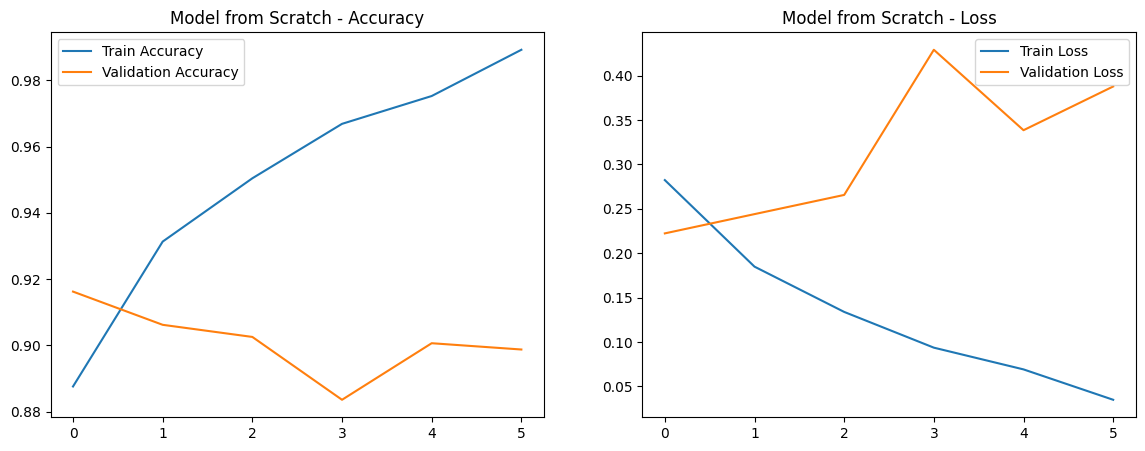

In [7]:
y_pred_scratch = (model_scratch.predict(X_test_pad) > 0.5).astype("int32")
print("Model trained from scratch - Accuracy:", accuracy_score(y_test, y_pred_scratch))
print(classification_report(y_test, y_pred_scratch))
plot_metrics(history_scratch, 'Model from Scratch')

In [8]:
embedding_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

In [9]:
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [13]:
model_pretrained = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

c:\Users\koval\DataAnalysisLab3\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [14]:
model_pretrained.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_pretrained = model_pretrained.fit(X_train_pad, y_train, validation_split=0.2, epochs=epochs, batch_size=64)

Epoch 1/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 66s 133ms/step - accuracy: 0.8095 - loss: 0.4281 - val_accuracy: 0.8685 - val_loss: 0.3239
Epoch 2/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 57s 124ms/step - accuracy: 0.8723 - loss: 0.3143 - val_accuracy: 0.8793 - val_loss: 0.2978
Epoch 3/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 57s 124ms/step - accuracy: 0.8863 - loss: 0.2799 - val_accuracy: 0.8999 - val_loss: 0.2628
Epoch 4/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 57s 124ms/step - accuracy: 0.8945 - loss: 0.2629 - val_accuracy: 0.9040 - val_loss: 0.2518
Epoch 5/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 57s 125ms/step - accuracy: 0.9013 - loss: 0.2475 - val_accuracy: 0.9027 - val_loss: 0.2574
Epoch 6/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 57s 125ms/step - accuracy: 0.9054 - loss: 0.2357 - val_accuracy: 0.9063 - val_loss: 0.2418
Epoch 7/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 59s 127ms/step - accuracy: 0.9131 - loss: 0.2153 - val_accuracy: 0.9040 - val_loss: 0.2486
Epoch 8/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 60s 129ms/step - accuracy: 0.9199 - loss: 0

289/289 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step
Model with Pretrained Embeddings - Accuracy: 0.9066160520607375
              precision    recall  f1-score   support

         0.0       0.91      0.90      0.91      4597
         1.0       0.90      0.91      0.91      4623

    accuracy                           0.91      9220
   macro avg       0.91      0.91      0.91      9220
weighted avg       0.91      0.91      0.91      9220



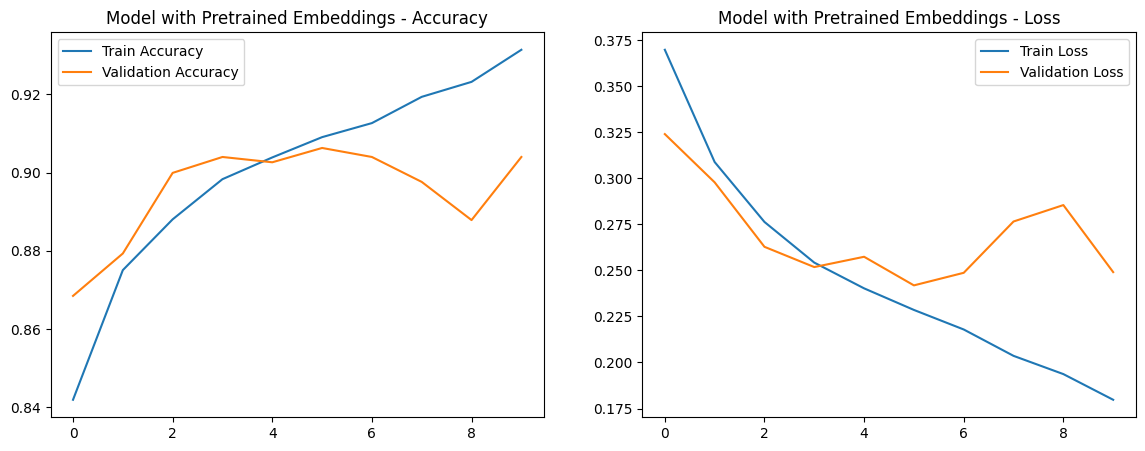

Scratch model accuracy: 0.911822125813449
Pretrained model accuracy: 0.9066160520607375


In [15]:
y_pred_pretrained = (model_pretrained.predict(X_test_pad) > 0.5).astype("int32")
print("Model with Pretrained Embeddings - Accuracy:", accuracy_score(y_test, y_pred_pretrained))
print(classification_report(y_test, y_pred_pretrained))
plot_metrics(history_pretrained, 'Model with Pretrained Embeddings')

# Compare models
print("Scratch model accuracy:", accuracy_score(y_test, y_pred_scratch))
print("Pretrained model accuracy:", accuracy_score(y_test, y_pred_pretrained))